# Building a parcellation of the mouse isocortex, from a perspective of connectomics
*Using Diffusion Mapping*

In this example, we will look at how use the module connectivity_parcellation of the flatmap_tools repository to regionalize the mouse isocortex and define a new parcellation scheme purely based on connectivity.

To do so, we are going to use the mathematical tool called diffusion mapping. This tools allows to reduce the dimensionality of data based on connectivity. Imagine a random walk on a graph: the connectivity will be estimated by the probability to jump from one node to another, while diffusing, the high probability pathways will get strengthen and the low probability pathways will get weaken. This will reveal an embedded geometrical space of connectivity on which we would be able to compute the diffusion distance between nodes (close to each other = high connectivity, far away form each other = low connectivity) (see De La Porte et al., 2008; Coifman & Lafon, 2006; Coifman et al., 2005 for more details about diffusion mapping). It works in 5 step:
- Build a connectivity  matrix between the regions to be flatten and the regions whose connectivity is to be considered. Either afferent connections, efferent or both.
- Build a similarity matrix from the connectivity matrix.
- Run Diffusion process.
- Compute Diffusion distance.
- Low-dimensional embedding: extract the 2 first eigenvectors and attribute them to an x and y interval in a 2d space.  

First, we define "modules" in the isocortex. We recall that the goal is to start from the isocortex and split as much as needed to get to a fine parcellation scheme. Since we are working with the voxelized connectivity model of the Allen Brain Institute, we make those modules from regions of the "traditional" parcellation scheme. The choice of these modules can be kind of arbitrary, but you would prefer to make them from neighbouring regions. Also, the bigger they are, the better.

In [1]:
import os
os.chdir('D:/Documents/Anaconda/flatmap_tools')

# List of all regions in the isocortex (established parcellation)
isocortex = ["FRP","MOs","ACAd","ACAv","PL","ILA","ORBl","ORBm","ORBvl",
                             "AId","AIv","AIp","GU","VISC",
                             "SSs","SSp-bfd","SSp-tr","SSp-ll","SSp-ul","SSp-un","SSp-n","SSp-m","MOp",
                             "VISal","VISl","VISp","VISpl","VISli","VISpor","VISrl",
                             "VISa","VISam","VISpm","RSPagl","RSPd","RSPv",
                             "AUDd","AUDp","AUDpo","AUDv","TEa","PERI","ECT"]


module_I = ['FRP', 'ORB', 'ACA', 'PL', 'ILA', 'AI']
module_II = ['MO']
module_III = ['SS']
module_IV = ['VISC', 'GU', 'AUD']
module_V = ['VIS', 'RSP', 'PTLp', 'TEa', 'PERI', 'ECT']

names = ['Module_I', 'Module_II', 'Module_III', 'Module_IV', 'Module_V']
acronyms = ['mod_I', 'mod_II', 'mod_III', 'mod_IV', 'mod_V']
modules = [module_I, module_II, module_III, module_IV, module_V]

To work with this library, you will need different configuration files:
- a structures.json: a list of all regions (or modules) with their information (name, acronym, id, id path...), this file will be used by the voxel connectivity model.
- a hierarchy.json: hierarchical tree of the brain's organization with information for each region.
- an annotation.nrrd: 3d voxel map of the brain. Each x/y/z coordinates has for value the id of the region it belongs to.
- a flattening_config.json: configuration file of the diffusion mapping (region to flatten, connectivity to consider, direction of connectivity, number of components, normalization arguments...).  

In addition, we suggest to use a split_manifest.json file, which contains all paths to the files stated above, with also path to anatomical and diffusion flatmaps, and the algorithm used to split regions and its hyperparameters. It avoids to call each time individually all these configuration files when using the different functions of this package.  

And finally, you will need a voxel_model_manifest.json, which is the configuration file of the voxelized brain connectivity model of the Allen Brain Institute. However, you will just need to change 2 words each time, one for the annotation and one for the structures. I personnaly prefer to do it manually but a function could be added later for this purpose.

Now let's create these configuration files for the new modules we defined. Note that you will need some model for that which are provided in this repository.

In [2]:
import json
split_manifest = './config_files/original/split_manifest_origin_cc.json'
with open(split_manifest, "r") as read_file:
    split_manifest = json.load(read_file)

# extract the initial configuration files we need
hierarchy = split_manifest.get('hierarchy')
annotation = split_manifest.get('annotation')
structures = split_manifest.get('structures')

# version of our trial
version = 'example'
# save at
out_str = f'./config_files/{version}/structures_{version}.json'
out_hier = f'./config_files/{version}/hierarchy_{version}.json'
out_ann = f'./config_files/{version}/annotation_100_{version}.nrrd'
out_config = f'./config_files/{version}/flattening_config_{version}.json'

In [ ]:
from connectivity_parcellation import start_modules_structures, start_modules_hierarchy, start_modules_annotation, start_modules_configuration
# Write structures
mod_structures = start_modules_structures(modules, names, acronyms, structures, hierarchy, out_str, save = True)
# Write hierarchy
mod_hierarchy = starting_modules_hierarchy(modules, names, acronyms, hierarchy, structures, out_hier, save = True)
# Write annotation, need the new hierarchy
mod_ann = starting_modules_annotation(modules, acronyms, annotation, out_hier, hierarchy, out_ann, save = True)
# Write the flattening config, need new hierarchy and new annotation, direction must be 'both', 'afferent' or 'efferent'
mod_config = starting_modules_configuration(acronyms, out_hier, out_ann, out_config, direction = 'both', save = True)

If you put these files in the same folder (for example in a folder named 'example') you can call the function write split manifest.  
Note that this function also includes the path to the diffusion flatmap, since that we don't have it yet, careful to use the same directory and name. You will also have to create a dictionary with the splitting algorithm and its hyperparameters *(useful if we implement others algorithms later)*.

In [ ]:
from connectivity_parcellation import write_split_manifest
path = f'./config_files/{version}/'

split_algo = {'algorithm' : 'SVM',
              'hyper_parameters' : 
                  {'C' : 0.1,
                   'gamma' : 0.01}}

# Flatmap of isocortex based on structural features, always the same
anatomical_fm = "./notebook/diffusion_embedding_thalamic_flatmap_plus_isocortex_v2.nrrd"

diffusion_fm = f'./flatmaps/diff_flatmap_{version}.nrrd' # CAREFUL TO MATCH EXACTLY THE SAME NAME WITH THE FLATMAP YOU WILL CREATE

manifest = write_split_manifest(version, path, anatomical_fm, diffusion_fm, split_algo, save=True)

Now final step is to create a voxel model manifest, to do it manually, simply copy paste the one in the original folder, open it and in the key 'STRUCTURE_TREE' change the path to your new structures file, and same for the key 'ANNOTATION' with your new annotation.  
You will also have to put this voxel manifest and the structures.json file in the mcmodels directory (should be a folder named 'connectivity' by default) and the annotation.nrrd in connectivity/annotation/ccf_2017/your_annotation.nrrd.  
We are finally done with all these files, now we can at least run the diffusion mapping of our modules !  
For that, run the script make_diffusion_flatmap.py, with arguments:
- --allen_cache: path to the voxel_model_manifest.json 
- --h5_cache: path to an h5 cache, if non existing it will write it.  
__IMPORTANT__ : This cache can grow BIG, around 56 GB for the whole isocortex, but since that we are working with only the right hemisphere, only 28 GB. But when buffering the connectivity data from one region to all the other, it can grow way bigger, especially that we are working with huge modules here. So be aware of that. And you might want to delete it before running a new diffusion mapping.
- --output_path
- --region_file: path to the flattening_config.json


## Example with the secondary somatomotor area (MOs)

To have a better understanding of what we are doing here, I propose an example of the framework with the secondary somatomotor area (MOs). MOs being defined by the established parcellation, we get further from the main goal of building a parcellation scheme from the isocortex. But this will give a good intuition about why this work is relevant  

The diffusion flatmap is a wonderful tool to express and visualize the organisation of connectivity between one region and all the others.  If we project in on the anatomical flatmap, we can look at the topological organisation of connectivity of this region with the others. 

d:\programdata\anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
d:\programdata\anaconda\envs\py37\lib\site-packages\voxel_maps\voxel_mapping.py:47: RuntimeWarning: invalid value encountered in true_divide
  img_out = img_out / counts_out


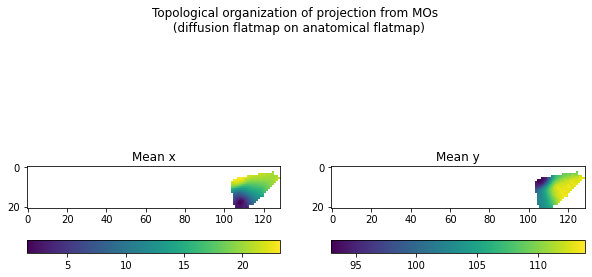

In [3]:
from voxel_maps import coordinates_to_image
import voxcell
import numpy
import matplotlib.pyplot as plt
import json
with open('./config_files/original/split_manifest_origin_cc.json', "r") as read_file:
    split_manifest = json.load(read_file)
    
anatomical_fm = split_manifest.get('anatomical_flatmap')
diffusion_fm = split_manifest.get('diffusion_flatmap')
annotation = split_manifest.get('annotation')
hierarchy = split_manifest.get('hierarchy')     
   
region = 'VISp'

anat = voxcell.VoxelData.load_nrrd(anatomical_fm)
diff = voxcell.VoxelData.load_nrrd(diffusion_fm)
ann = voxcell.VoxelData.load_nrrd(annotation)
hier = voxcell.Hierarchy.load_json(hierarchy)

mask = numpy.all((~numpy.isnan(diff.raw)) & (diff.raw > -1), axis=3)
ann_vals = ann.raw[mask]
xy = anat.raw[mask]
ab = diff.raw[mask]
tgt_region_ids = list(hier.collect('acronym', region, 'id'))
sub_xy = xy[numpy.in1d(ann_vals, tgt_region_ids)]
sub_ab = ab[numpy.in1d(ann_vals, tgt_region_ids)]
tmp_img = coordinates_to_image(sub_ab, sub_xy)
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
im = ax1.imshow(tmp_img[:, :, 0])
fig.colorbar(im, ax=ax1, orientation='horizontal')
ax1.set_title("Mean x")
ax2 = fig.add_subplot(1, 2, 2)
im1 = ax2.imshow(tmp_img[:, :, 1])
fig.colorbar(im1, ax=ax2, orientation='horizontal')
ax2.set_title("Mean y")
plt.suptitle('Topological organization of projection from MOs \n (diffusion flatmap on anatomical flatmap)', y = 1.05)
plt.show()

By assuming that 2 regions are connected by a large bundle of fibers, and even thought they would be distorded a bit along the way, innervation location and innervated location will remain more or less parallel. Therefore, the expected 2 dominant gradients of connectivity would be one through the x axis and one through the y axis, therefore being orthogonal to each other.  
To go further in the visualization, we can plot the gradients of the x and y axis of the diffusion flatmap for each pixel of the anatomical flatmap.

d:\programdata\anaconda\envs\py37\lib\site-packages\voxel_maps\voxel_mapping.py:47: RuntimeWarning: invalid value encountered in true_divide
  img_out = img_out / counts_out
D:\Documents\Anaconda\flatmap_tools\connectivity_parcellation\split_regions.py:55: RuntimeWarning: invalid value encountered in greater
  mask = numpy.all((~numpy.isnan(viz.raw)) & (viz.raw > -1), axis=3)


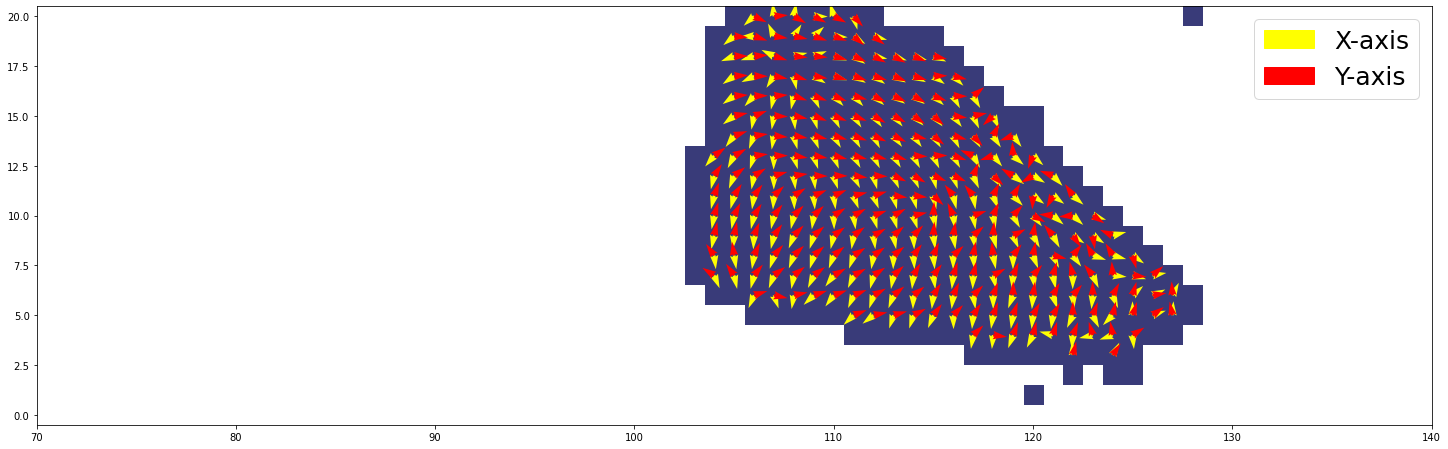

In [4]:
from connectivity_parcellation import flatmap_to_coordinates, gradient_map

# flatmap_to_coordinates returns the 3d coordinates of a region and its 2d coordinates of a specific flatmap, here we using the anatomical one
coordinates_3d, coordinates_2d = flatmap_to_coordinates(region, annotation, anatomical_fm, hierarchy)

# Create a image of this flatmap, will be used later
img_data =  numpy.empty((numpy.amax(coordinates_2d[:,0])+1,numpy.amax(coordinates_2d[:,1])+1))
img_data[:] = numpy.nan
for xy in coordinates_2d:
    img_data[xy[0],xy[1]] = 0

# Return the x/y directions of the gradient of the X and Y axis, show = True displays the gradient map
gX1, gY1, gX2, gY2 = gradient_map(anat, diff, ann, hier, region, show=True, normalize=True)

Now we can clearly see the topological organization of connectivity of MOs is nothing like we expected. The question one can ask here is what if instead of considering MOs as a whole, we consider it as two separated regions, cutting right where the y gradient are brutally changing.  
The splitting algorithm works in 4 steps:
- Compute the degree of the angle between the x and y gradients, and classify the pixel based on this angle (actual paramaters: class 1 = angle =< 90°, class 2 = angle > 90°).
- Assign this classification to the corresponding voxels. Since we can't classify all the voxels, because of the nature of this gradient map (need some contour pixels) and that data is loss along the flattening process, we use a Support Vector Machine with the x/y/z coordinates of the voxel as variables.
- Hierarchical clustering of the voxels of the same class to extract different subregions within the same class (classes can be spreaded at different places of the region).
- Extraction of the coordinates of these new subregions and write new configuration files with this new parcellation.  

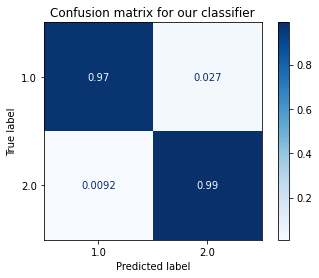

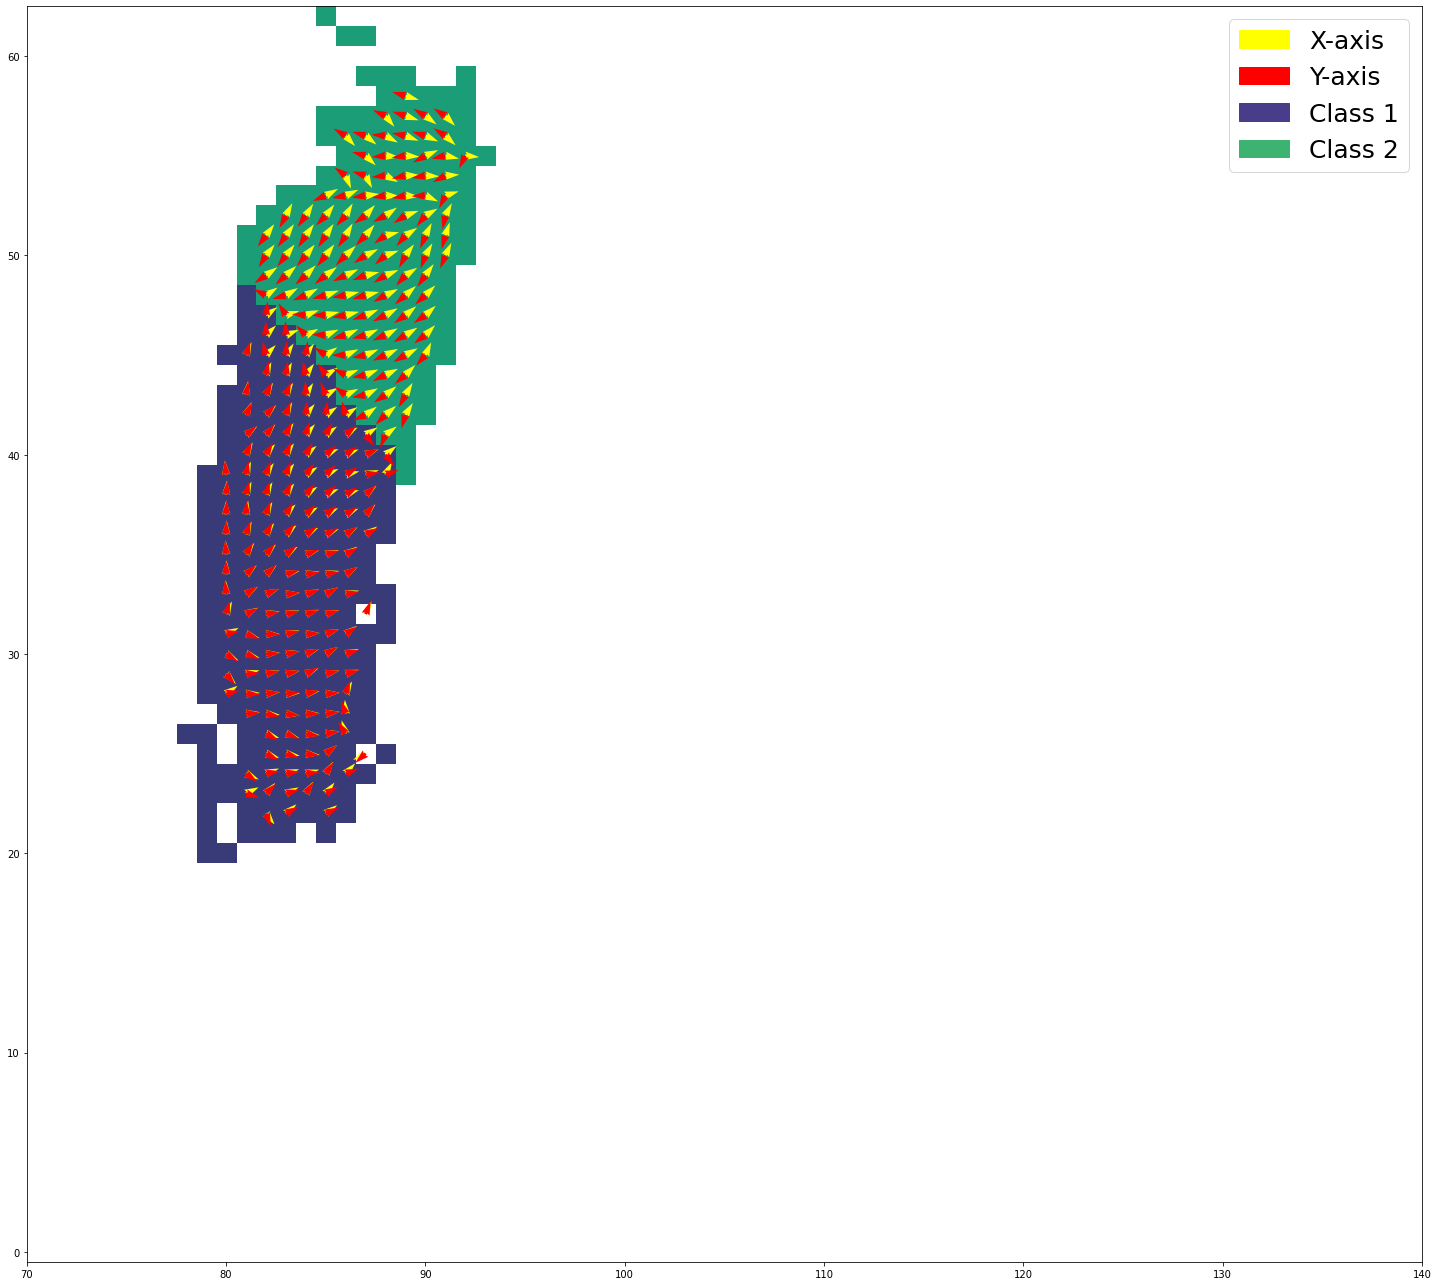

In [8]:
from connectivity_parcellation import degree_matrix, gradient_classification, split_with_SVM, viz_gradient_split, extract_subregions

# Step 1: Compute the angle between x and y gradient, return a matrix of the flatmap with as values the degree
deg_arr = degree_matrix(gX1, gY1, gX2, gY2)

# Step 2: Classification of the degree and assign it to the 3d coordinates
coordinates_3d_clf = gradient_classification(deg_arr, coordinates_2d, coordinates_3d)

# Classify the totality of the voxel with SVM, returns coordinates of the voxels of the 2 classes, show = True will display classification metrics
C_param = split_manifest.get('split_algo').get('hyper_parameters').get('C')
gamma_param = split_manifest.get('split_algo').get('hyper_parameters').get('gamma')
coords_sub1, coords_sub2 = split_with_SVM(coordinates_3d_clf, c=C_param, gamma=gamma_param, show=True)

# To look at the split on the 2d gradient map. ONLY FOR VISUALIZATION PURPOSE: the subregions are determined with voxels coordinates.
# compute the degree angle and classify it.
viz_gradient_split(gX1, gY1, gX2, gY2, coordinates_2d, img_data, c=C_param, gamma=gamma_param)

# Step 3: Apply hierarchical clustering extract the subregions coordinates in a list. Use Euclidean Distance, the distance criterion is set to 3.
lst_sub_regions = extract_subregions(coords_sub1, coords_sub2, t=3)

You can also use the function banana_split to do all of this at once. Keeping the arguments C = None and gamma = None will make the algorithm to use the hyperparameters provided by the split manifest. Or you can just give them the value you want. show = True will call the function viz_gradient_split and will plot the classified pixels.

d:\programdata\anaconda\envs\py37\lib\site-packages\voxel_maps\split_regions.py:55: RuntimeWarning: invalid value encountered in greater
  mask = numpy.all((~numpy.isnan(viz.raw)) & (viz.raw > -1), axis=3)
d:\programdata\anaconda\envs\py37\lib\site-packages\voxel_maps\voxel_mapping.py:47: RuntimeWarning: invalid value encountered in true_divide
  img_out = img_out / counts_out


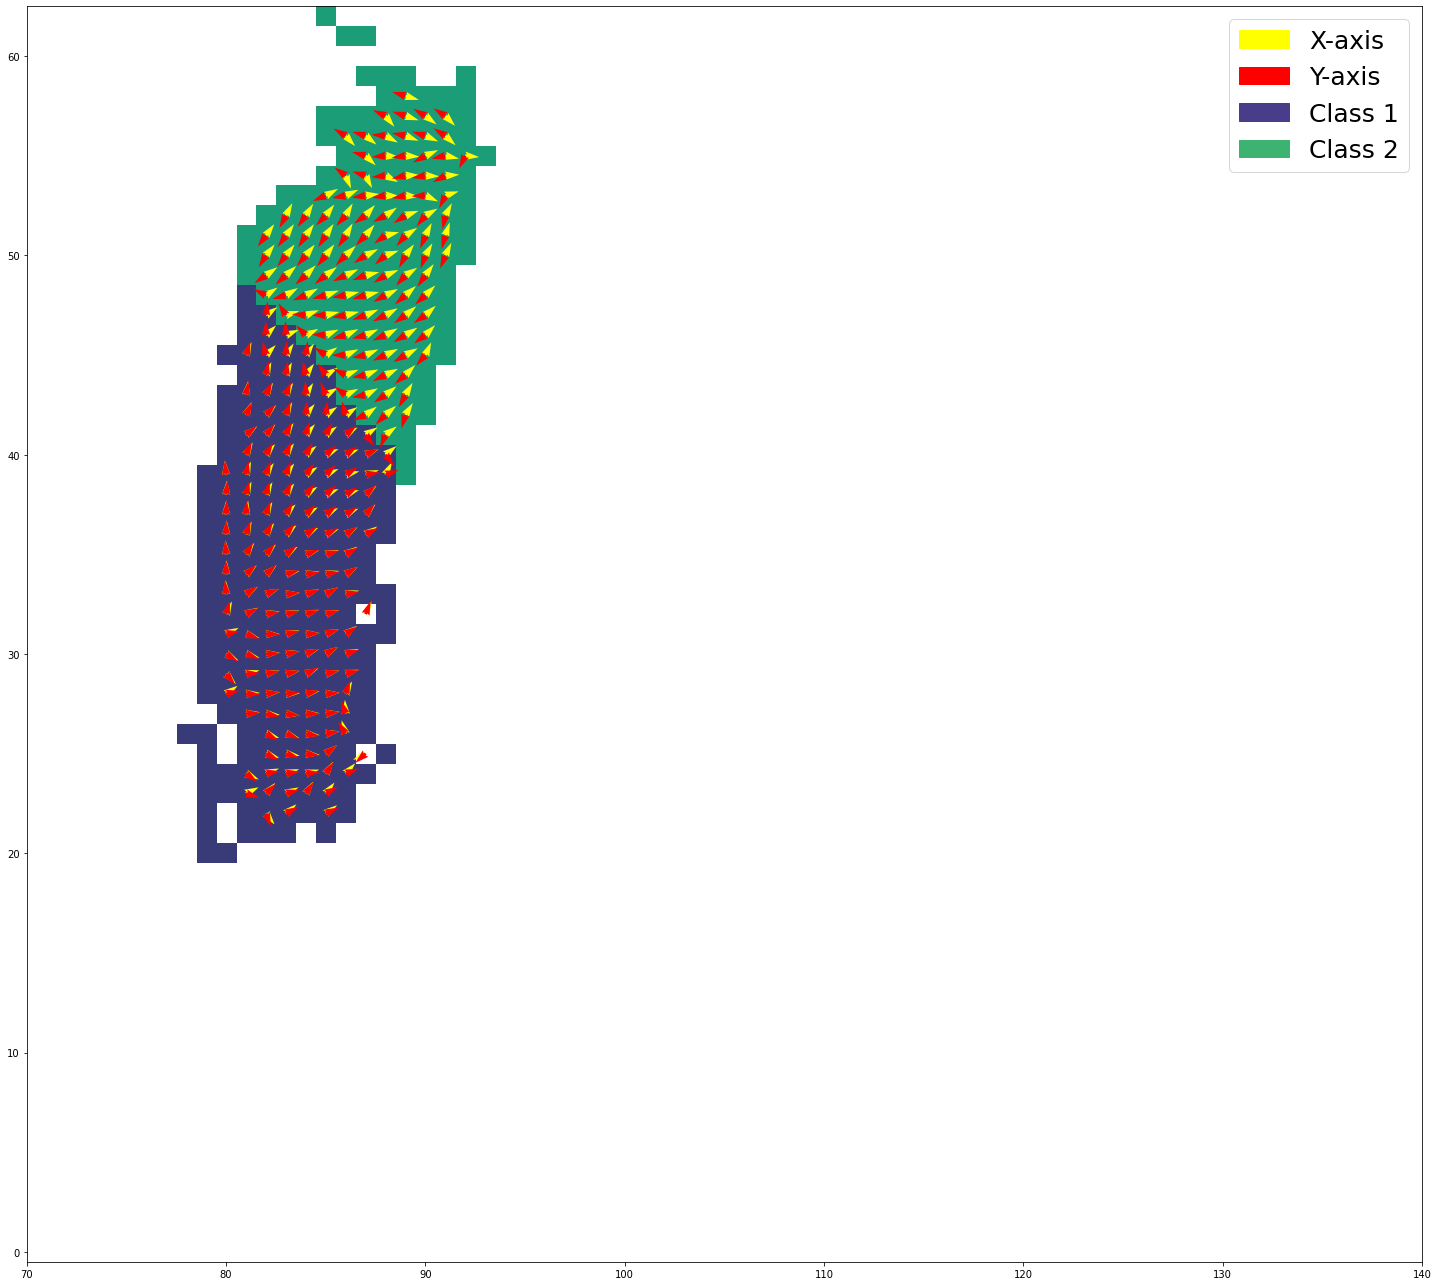

In [9]:
# from connectivity_parcellation import banana_split
from voxel_maps import banana_split
lst_subregions = banana_split(region, split_manifest, show = True, C = None, gamma = None)

Now, if you have plotly installed and built in your jupyter notebook, you can run the next cell to look at how it looks like in 3d. It shows a 3d scatterplot where each dot corresponds to a voxel. It is a nice way to visualize the result and plotly makes it very nice to interact with.

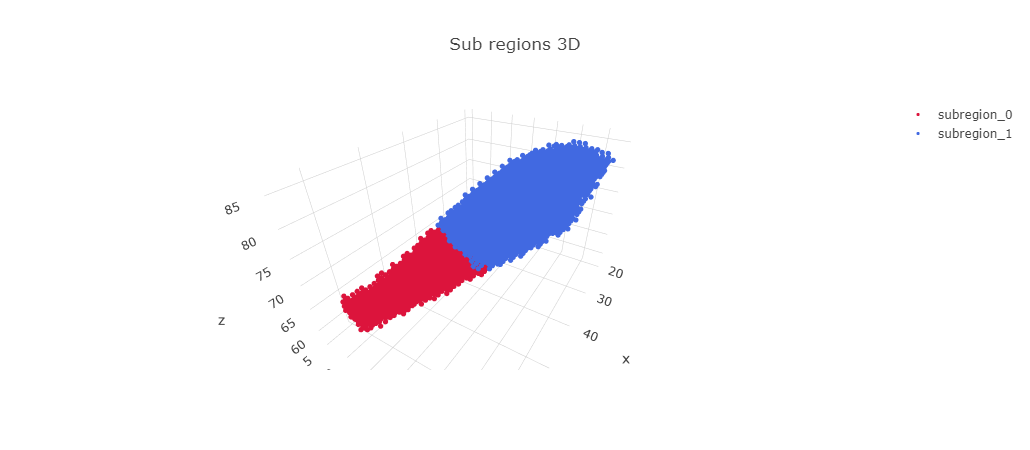

In [7]:
from plotly.offline import iplot
palette = ['crimson', 'royalblue', 'limegreen', 'cyan',
            'darkgoldenrod', 'darkgray', 'darkgreen',
            'darkkhaki', 'darkmagenta', 'darkorange',
            'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
            'darkslateblue', 'darkslategray', 'darkslategrey',
            'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
            'dimgray','dimgrey', 'dodgerblue', 'firebrick',
            'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro',
            'ghostwhite', 'gold', 'goldenrod', 'gray', 'green',
            'greenyellow', 'honeydew', 'hotpink', 'indianred', 'indigo',
            'mediumorchid','linen', 'magenta', 'maroon', 'mediumaquamarine',
                'mediumblue', 'darkcyan', 'mediumpurple',
                'mediumseagreen', 'mediumslateblue', 'mediumspringgreen',
                'mediumturquoise', 'mediumvioletred', 'midnightblue',
                'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy',
                'oldlace', 'olive', 'olivedrab', 'orange', 'orangered',
                'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise',
                'palevioletred', 'papayawhip']

sub_plot = []
i = 0
for subregion in lst_subregions:
#     subregion = subregion * (100,100,100)
    colour = palette[i]
    name = str('subregion_' + str(i))
    i += 1
    X = subregion[:,0]
    Y = subregion[:,1]
    Z = subregion[:,2]
    sub_plot.append(
        dict(
        mode = "markers",
        name = name,
        type = "scatter3d",
        x = X, y = Y, z = Z,
        marker = dict(size=3, color=colour)
        )
    )
layout = dict(
    title = 'Sub regions 3D',
    scene = dict(
        xaxis = dict(zeroline=False),
        yaxis = dict(zeroline=False),
        zaxis = dict(zeroline=False),
    )
)
fig = dict(data=sub_plot, layout=layout)
iplot(fig, filename='Sub regions 3D')


The 4th step consists in writing configuration files with our new splitted MOs. The functions in the script write_configs.py run the function banana_split for each region we want to split, and write the configuration files with respect to the new brain parcellation scheme. It will add _a, _b, _c ... after the name of the splitted region for the number of subregions we get, and add 10, 20, 30 ... to the id of these new subregions.  Let's do it first by splitting only MOs. Make sure to create a new folder for your new configuration files, and if you've find better hyperparameters for the SVM you will have to edit the split_manifest.

In [ ]:
from parcellation_connectivity import write_structures_file, write_annotation_file, write_hierarchy_file, write_flatmap_config_file

new_version = 'example_split_1'

out_str = f'./config_files/{new_version}/structures_{new_version}.json
out_hier = f'./config_files/{new_version}/hierarchy_{new_version}.json'
out_ann = f'./config_files/{new_version}/annotation_100_{new_version}.nrrd'
out_config = f'./config_files/{new_version}/flattening_config_{new_version}.json'

regions_to_split = ['MOs']

# Write structures.json
new_structure = write_structures_file(regions_to_split, split_manifest, out_str, save=True)

# Write annotation.nrrd
new_annotation = write_annotation_file(regions_to_split, split_manifest, out_ann, save=True)

# Write hierarchy.json
new_hierarchy = write_hierarchy_file(regions_to_split, split_manifest, out_conf, save=True)

# Write diffusion flattening configuration.json with the new annotation and hierarchy files
new_config = write_flatmap_config_file(regions_to_split, split_manifest, out_ann, out_hier, out_config, save=True)

In [ ]:
from connectivity_parcellation import write_split_manifest

# Write splitting configuration.json
path = f'./config_files/{new_version}/'

split_algo = {'algorithm' : 'SVM',
              'hyper_parameters' : 
                  {'C' : 0.1,
                   'gamma' : 0.01}}

anatomical_fm = "./notebook/diffusion_embedding_thalamic_flatmap_plus_isocortex_v2.nrrd"
diffusion_fm = f'./flatmaps/diff_flatmap_{new_version}.nrrd' # CAREFUL TO MATCH EXACTLY THE SAME NAME WITH THE FLATMAP YOU ARE CREATING

new_manifest = write_split_manifest(version, path, anatomical_fm, diffusion_fm, split_algo, save=True)

You can now run a new diffusion mapping with this new parcellation ! You will need before to write a new voxel model manifest, put the right files at their right location (voxel_model_manifest, structures and annotation) and probably delete the h5 cache. Let's take a look at the results.

In [10]:
# split_manifest = f'./config_files/{new_version}/split_manifest_{new_version}.json'

with open('./config_files/testv1/split_manifest_testv1.json', 'r') as read_file: # to remove (testv1)
    split_manifest = json.load(read_file)                                       


with open(split_manifest.get('configuration_flatmap'), 'r') as read_file:
    config = json.load(read_file)
cortex_regions = config[0]['connectivity_target']['considered_regions']
print(cortex_regions) # result of testv1, which splitted several regions, not just MOs

['FRP', 'MOs_b', 'MOs_a', 'ACAd_c', 'ACAd_b', 'ACAd_a', 'ACAv_b', 'ACAv_a', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 'AId_b', 'AId_a', 'AIv_b', 'AIv_a', 'AIp', 'GU', 'VISC_b', 'VISC_a', 'SSs_b', 'SSs_a', 'SSp-bfd', 'SSp-tr', 'SSp-ll', 'SSp-ul', 'SSp-un', 'SSp-n', 'SSp-m', 'MOp_c', 'MOp_b', 'MOp_a', 'VISal', 'VISl', 'VISp', 'VISpl', 'VISli', 'VISpor', 'VISrl', 'VISa', 'VISam', 'VISpm_b', 'VISpm_a', 'RSPagl_b', 'RSPagl_a', 'RSPd_b', 'RSPd_a', 'RSPv', 'AUDd', 'AUDp', 'AUDpo', 'AUDv', 'TEa_b', 'TEa_a', 'PERI', 'ECT_b', 'ECT_a']


Since for all regions we consider the connectivity from all the others regions, this line config[0]['connectivity_target']['considered_regions'] is an easy way to collect all the regions from the new parcellation. We can see here the number of subregions resulting from the splitting of MOs.

d:\programdata\anaconda\envs\py37\lib\site-packages\voxel_maps\voxel_mapping.py:47: RuntimeWarning: invalid value encountered in true_divide
  img_out = img_out / counts_out
d:\programdata\anaconda\envs\py37\lib\site-packages\voxel_maps\split_regions.py:55: RuntimeWarning: invalid value encountered in greater
  mask = numpy.all((~numpy.isnan(viz.raw)) & (viz.raw > -1), axis=3)


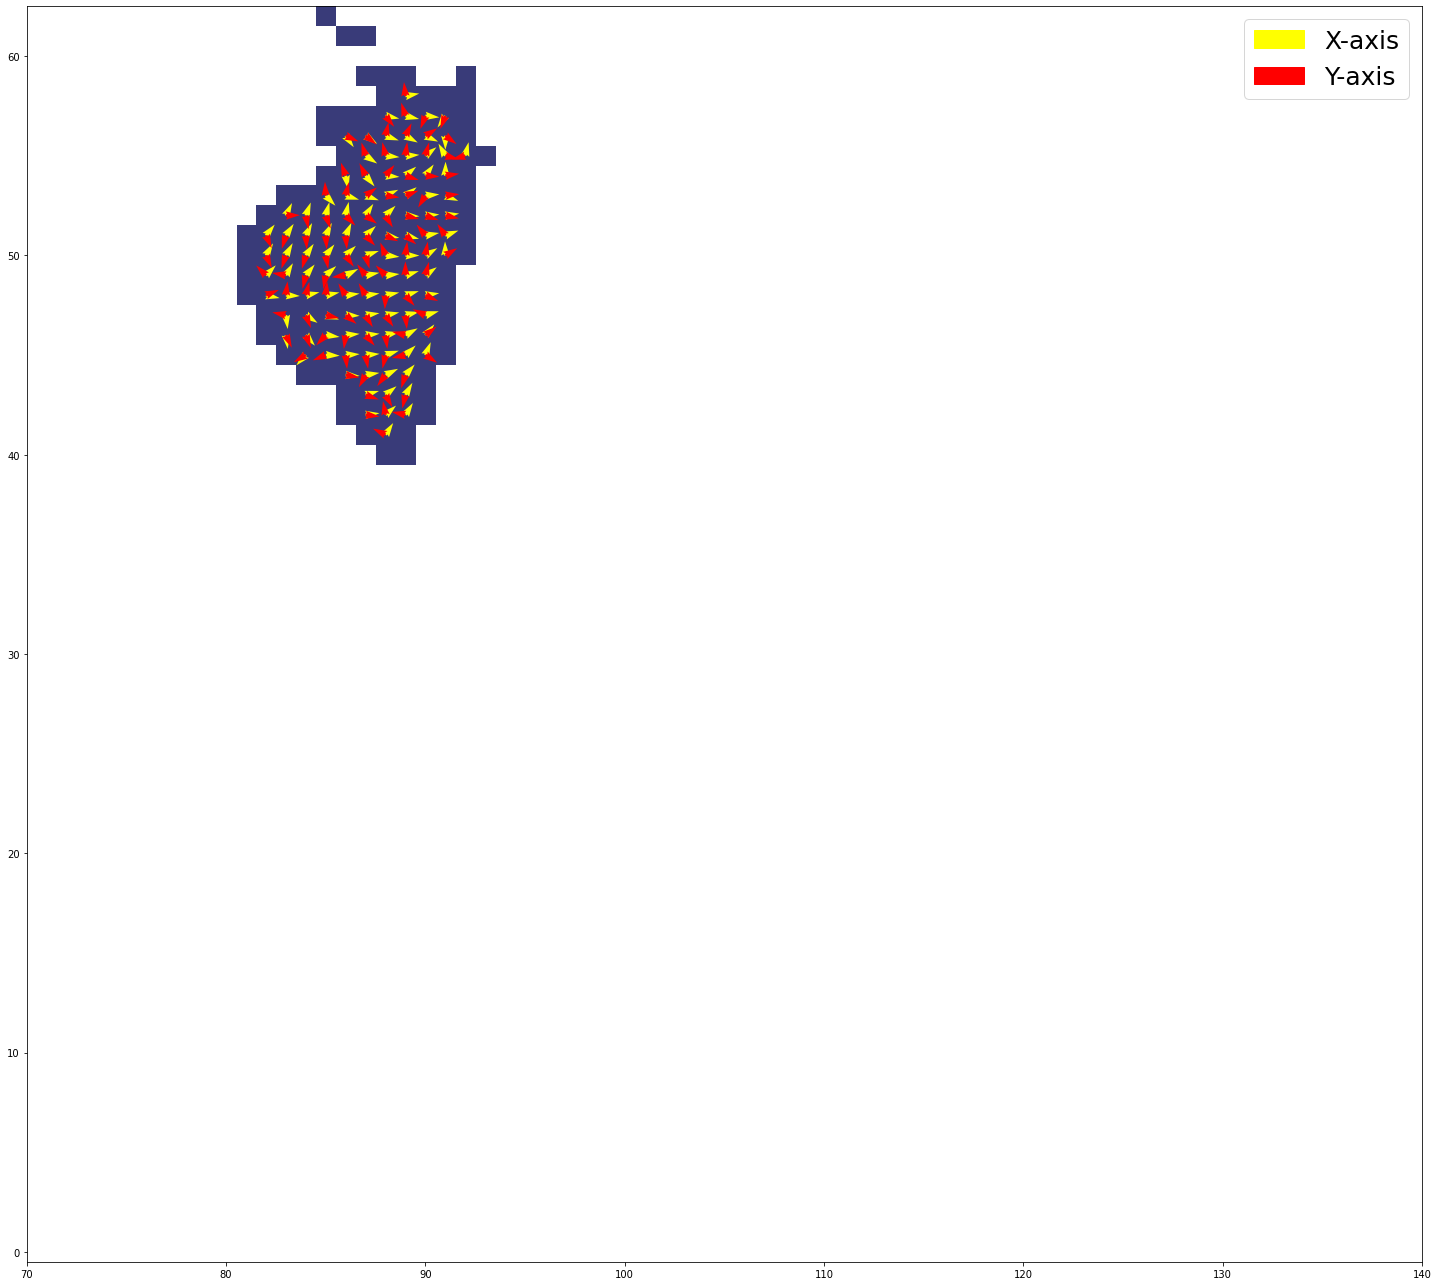

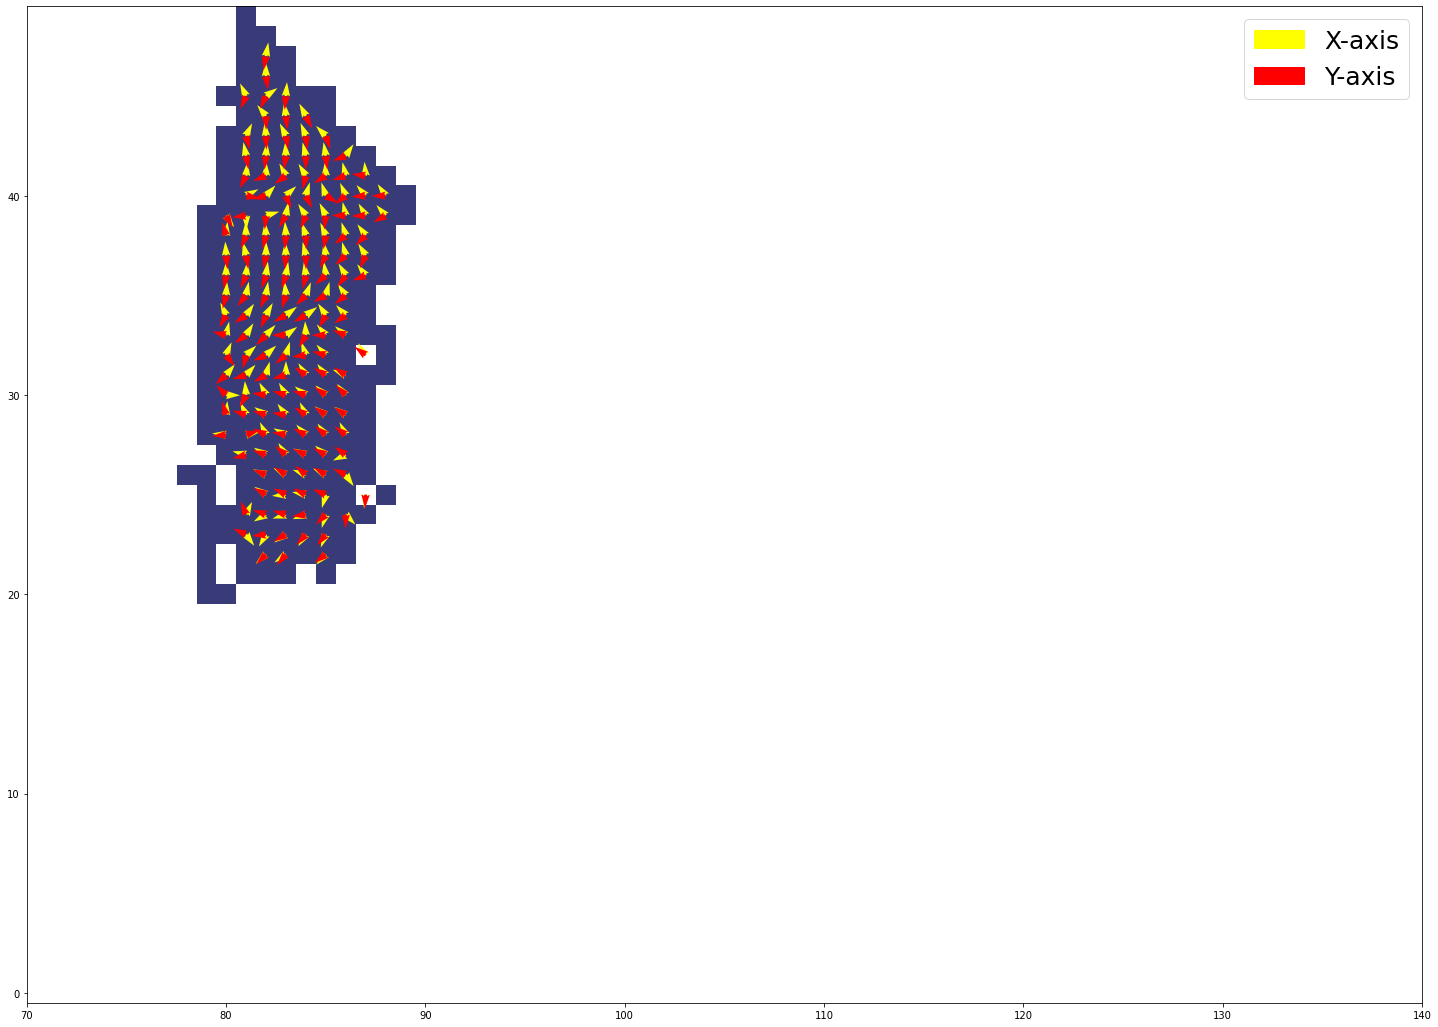

In [11]:
anat = voxcell.VoxelData.load_nrrd(split_manifest.get('anatomical_flatmap'))
diff = voxcell.VoxelData.load_nrrd(split_manifest.get('diffusion_flatmap'))
ann = voxcell.VoxelData.load_nrrd(split_manifest.get('annotation'))
hier = voxcell.Hierarchy.load_json(split_manifest.get('hierarchy'))

regions = ['MOs_a', 'MOs_b']
for region in regions:
    gX1, gY1, gX2, gY2 = gradient_map(anat, diff, ann, hier, region, show=True, normalize=True)

Visually, the "anomaly" of gradients seems to be reduced, at least for MOs_a. We can call the function plot_gradient_deviation to visualize with box plot how much the angle between the x and y gradients deviates from 90°. 

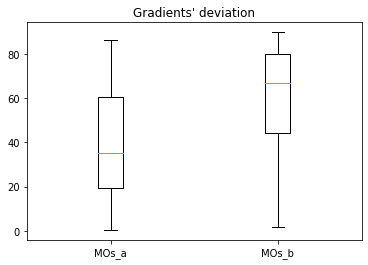

In [12]:
from connectivity_parcellation import plot_gradient_deviation

plot_gradient_deviation(regions, split_manifest, show_map=False) #show_map = True will display the gradient map

Indeed ! The deviation for MOs_a drastically reduced comparted to MOs_b. Note that in this established parcellation scheme, the somatomotor areas are not specialized, so you might want to split them more than once.  
Alright ! That's it for the example, you have everything in your hand to use this package and build your own connectivity-based parcellation scheme ! Now we can back to the modules we defined at the very start.

## Result of Trial I

In this part we are going to look at some tools to evaluate the results, what information we can extract from our new parcellation. This part is in development, few tools are currently available but new ones will are on their way.  
By using the exact same method we've seen with the MOs example, from the 5 define modules we defined a parcellation scheme with 42 regions after 3 splits, so 3 diffusion mapping (however this is not the final result, more splitting can be done!).  
Wee can see how it looks like with plotly.

In [4]:
import os
import voxcell
import numpy
import nrrd
import json
from plotly.offline import iplot

os.chdir('D:/Documents/Anaconda/flatmap_tools')
version = 'I_split_3'

split_manifest = f'./config_files/modules_{version}/split_manifest_{version}.json'

with open(split_manifest, "r") as read_file:
        split_manifest = json.load(read_file)

with open(split_manifest.get('configuration_flatmap'), "r") as read_file:
        config = json.load(read_file)

cortex_modules = config[0]['connectivity_target']['considered_regions']
print(cortex_modules)

ann, _ = nrrd.read(split_manifest.get('annotation'))
hiervox = voxcell.Hierarchy.load_json(split_manifest.get('hierarchy'))

['mod_I_b_d_b', 'mod_I_b_d_a', 'mod_I_b_c', 'mod_I_b_b_b', 'mod_I_b_b_a', 'mod_I_b_a_b', 'mod_I_b_a_a', 'mod_I_a_b_b', 'mod_I_a_b_a', 'mod_I_a_a', 'mod_II_b_d', 'mod_II_b_c_c', 'mod_II_b_c_b', 'mod_II_b_c_a', 'mod_II_b_b_b', 'mod_II_b_b_a', 'mod_II_b_a', 'mod_II_a_b_c', 'mod_II_a_b_b', 'mod_II_a_b_a', 'mod_II_a_a', 'mod_III_b_b_b', 'mod_III_b_b_a', 'mod_III_b_a_b', 'mod_III_b_a_a', 'mod_III_a_b_c', 'mod_III_a_b_b', 'mod_III_a_b_a', 'mod_III_a_a_c', 'mod_III_a_a_b', 'mod_III_a_a_a', 'mod_IV_b_c_b', 'mod_IV_b_c_a', 'mod_IV_b_b', 'mod_IV_b_a_b', 'mod_IV_b_a_a', 'mod_IV_a_b', 'mod_IV_a_a', 'mod_V_b_b_b', 'mod_V_b_b_a', 'mod_V_b_a', 'mod_V_a']


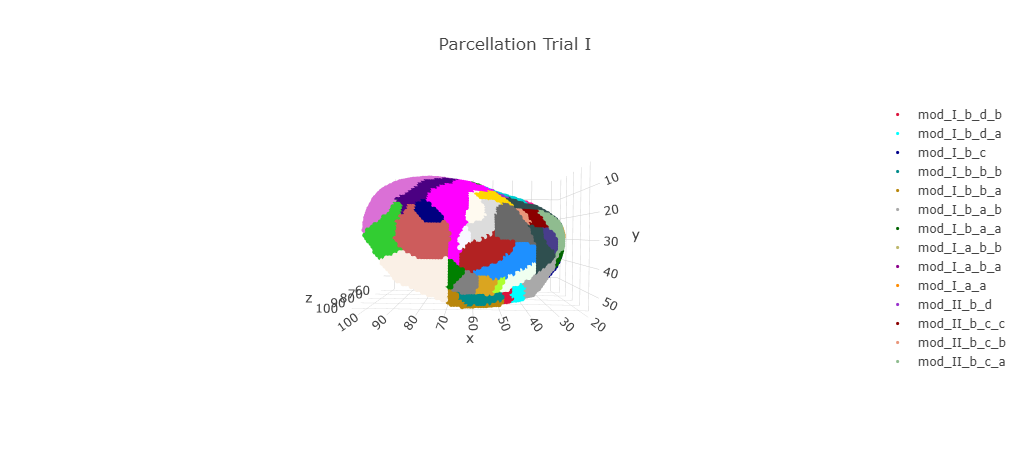

In [15]:
palette = ['crimson', 'cyan', 'darkblue', 'darkcyan',
            'darkgoldenrod', 'darkgray', 'darkgreen',
            'darkkhaki', 'darkmagenta', 'darkorange',
            'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
            'darkslateblue', 'darkslategray', 'darkslategrey',
            'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
            'dimgray','dimgrey', 'dodgerblue', 'firebrick',
            'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro',
            'ghostwhite', 'gold', 'goldenrod', 'gray', 'green',
            'greenyellow', 'honeydew', 'navy', 'indianred', 'indigo',
            'limegreen','linen', 'orchid', 'maroon', 'mediumaquamarine',
                'mediumblue', 'mediumorchid', 'mediumpurple',
                'mediumseagreen', 'mediumslateblue', 'mediumspringgreen',
                'mediumturquoise', 'mediumvioletred', 'midnightblue',
                'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'hotpink',
                'oldlace', 'olive', 'olivedrab', 'orange', 'orangered',
                'magenta', 'palegoldenrod', 'palegreen', 'paleturquoise',
                'palevioletred', 'papayawhip']

sub_plot = []
i = 0
for region in cortex_modules:
    lst_vxl_id = list(hiervox.collect('acronym', region, 'id'))
    coords = []
    for vxl_id in lst_vxl_id:
        for x in range(int(ann.shape[0])):
            for y in range(int(ann.shape[1])):
                for z in range(int(ann.shape[2])):
                    if ann[x,y,z] == vxl_id:
                        coords.append([x,y,z])
    coords = numpy.vstack(coords)
    colour = palette[i]
    i += 1
    X = coords[:,0]
    Y = coords[:,1]
    Z = coords[:,2]
    sub_plot.append(
        dict(
        mode = "markers",
        name = region,
        type = "scatter3d",
        x = X, y = Y, z = Z,
        marker = dict(size=3, color=colour)
        )
    )
layout = dict(
    title = 'Parcellation Trial I',
    scene = dict(
        xaxis = dict(zeroline=False),
        yaxis = dict(zeroline=False),
        zaxis = dict(zeroline=False),
    )
)
fig = dict(data=sub_plot, layout=layout)
iplot(fig, filename='Parcellation Trial I')

We can compare it to the established parcellation by plotting the overlaps between these two parcellation schemes, i.e. the amount of one region from parellation A contained in a region from parcellation B. You will need the original split_manifest for that.

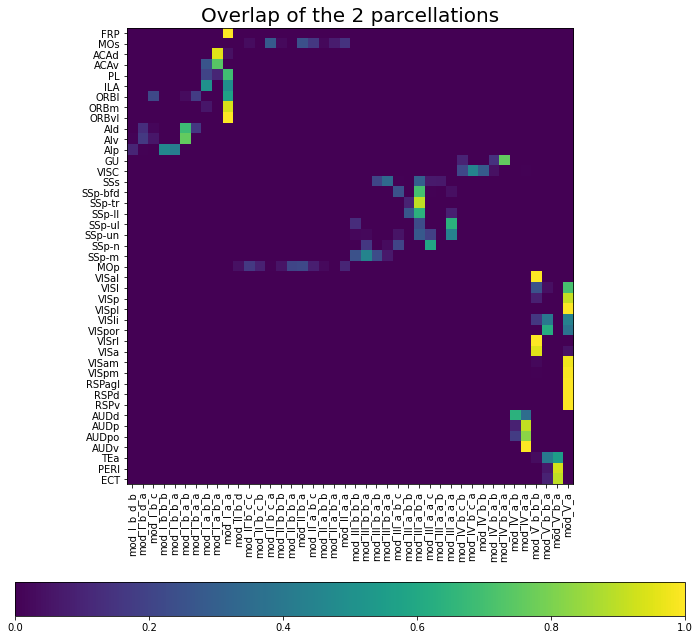

In [5]:
from connectivity_parcellation import dataframe_original_regions, dataframes_splits, overlap_two_parcellations

original_manifest = './config_files/original/split_manifest_origin_cc.json'

# We first build dataframe with, for each regions of parcellation A (here the established one) the number of voxels and the distribution
isocortex = ["FRP","MOs","ACAd","ACAv","PL","ILA","ORBl","ORBm","ORBvl",
                             "AId","AIv","AIp","GU","VISC",
                             "SSs","SSp-bfd","SSp-tr","SSp-ll","SSp-ul","SSp-un","SSp-n","SSp-m","MOp",
                             "VISal","VISl","VISp","VISpl","VISli","VISpor","VISrl",
                             "VISa","VISam","VISpm","RSPagl","RSPd","RSPv",
                             "AUDd","AUDp","AUDpo","AUDv","TEa","PERI","ECT"]

df_a = dataframe_original_regions(isocortex, original_manifest, right_hemisphere = True) # For now, we are working with the right hemisphere only

# Make a dataframe for each region of parcellation B with number of voxels from regions of parcellation A, the distribution and the ratio.
# Returns a dictionary of dataframes
dfs_b = dataframes_splits(cortex_modules, split_manifest, original_manifest, df_a)

# Now plot the overlap, returns also a data frame of the ratio of each region of parcellation A in regions of parcellation B
df_ratio = overlap_two_parcellations(dfs_b, isocortex, cortex_modules)

We can also collect interesting insight by looking at the mutual information of these 2 parcellations. More precisely, we can look at how much information we gain (or entropy we loose) of the regions' distribution after each split. Basically, the more information we gain, the more aligned these 2 parellations are.

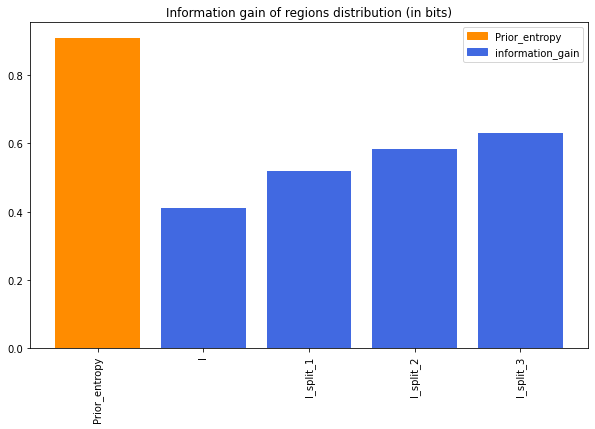

In [4]:
from connectivity_parcellation import information_gain, plot_info_gain

splits = ['I', 'I_split_1', 'I_split_2', 'I_split_3']

lst_info_gain = []
for split in splits:
    with open(f'./config_files/modules_{split}/split_manifest_{split}.json', "r") as read_file:
            split_manifest = json.load(read_file)          
    with open(split_manifest.get('configuration_flatmap'), "r") as read_file:
            config = json.load(read_file) 
    cortex_modules = config[0]['connectivity_target']['considered_regions']
    
    df_a = dataframe_original_regions(isocortex, original_manifest)
    dfs_b = dataframes_splits(cortex_modules, split_manifest, original_manifest, df_a)
    info_gain, prior_entropy = information_gain(df_a, dfs_b)
    lst_info_gain.append(info_gain)

plot_info_gain(prior_entropy, lst_info_gain, method = 'regions', lst_names = splits) # if don't provide name, plot one bar 'prior_entropy' and one bar 'split'

For this trial, we see that the more split we do the more information we gain. Now, we can also do the same for the distribution of layers. This one is important because it tells about the quality of the cut. Since we don't want to tear the layers apart and that we want clean vertical cut of the structure through layers, the entropy of the distribution of the layers should stay the same. For that we call functions to build dataframe but specific to layers.

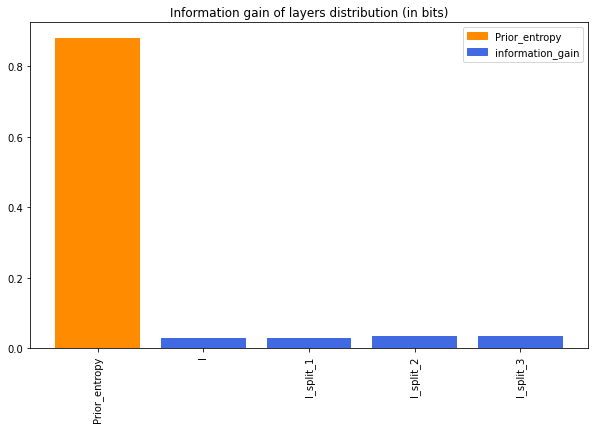

In [7]:
from connectivity_parcellation import dataframe_original_layers, dataframes_splits_layers

lst_info_gain = []
for split in splits:
    with open(f'./config_files/modules_{split}/split_manifest_{split}.json', "r") as read_file:
            split_manifest = json.load(read_file)          
    with open(split_manifest.get('configuration_flatmap'), "r") as read_file:
            config = json.load(read_file) 
    cortex_modules = config[0]['connectivity_target']['considered_regions']
    
    df_a = dataframe_original_layers(isocortex, original_manifest)
    dfs_b = dataframes_splits_layers(cortex_modules, split_manifest, original_manifest, df_a)
    info_gain, prior_entropy = information_gain(df_a, dfs_b)
    lst_info_gain.append(info_gain)

plot_info_gain(prior_entropy, lst_info_gain, method = 'layers', lst_names = splits)

Now we can see that the entropy of the layers' distribution stays more or less at the same level, how we wanted it to be. This is a nice metric to validate if the split is good.

### Pre-image of the diffusion flatmap  
Another point that is worth to be adressed is how the pre-image of the diffusion flatmap looks like. A flatmap is the projection of a 3d voxel map into a 2d space, therefore it is important that the pre-image of pixels of the flatmap, i.e. the voxels projected in a specific pixel, is mostly connected (voxels are 'touching' each other).  
To look at the pre-image of a flatmap, anatomical or diffusion, we can use the function find_pre_images. We are going to look here in a first time at the pre image of the anatomical flatmap of MOs and in a second time of the diffusion flatmap.

In [4]:
from connectivity_parcellation import find_pre_images

split_manifest = './config_files/modules_I_split_3/split_manifest_I_split_3.json'
region = 'mod_V_a'
# Returns a list of pre images with a list of the pixel x/y coordinations, and also can return the 3d coordinates of the region to plot
# n = number of random pixels to extract the pre image from
pre_images, pxl_idx, coords_3d = find_pre_images(region, split_manifest, method = 'anatomical', n=10)

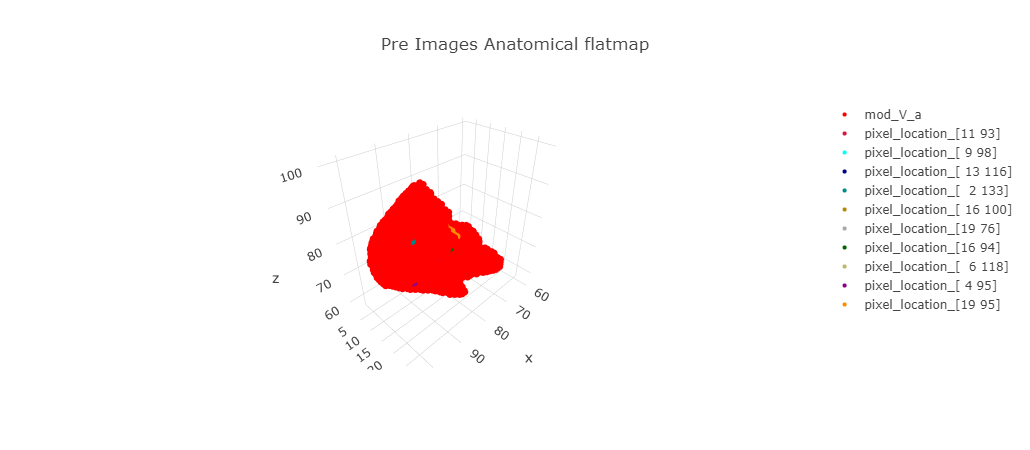

In [5]:

from plotly.offline import iplot
palette = ['crimson', 'cyan', 'darkblue', 'darkcyan',
            'darkgoldenrod', 'darkgray', 'darkgreen',
            'darkkhaki', 'darkmagenta', 'darkorange',
            'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
            'darkslateblue', 'darkslategray', 'darkslategrey',
            'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
            'dimgray','dimgrey', 'dodgerblue', 'firebrick',
            'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro',
            'ghostwhite', 'gold', 'goldenrod', 'gray', 'green',
            'greenyellow', 'honeydew', 'hotpink', 'indianred', 'indigo',
            'limegreen','linen', 'magenta', 'maroon', 'mediumaquamarine',
                'mediumblue', 'mediumorchid', 'mediumpurple',
                'mediumseagreen', 'mediumslateblue', 'mediumspringgreen',
                'mediumturquoise', 'mediumvioletred', 'midnightblue',
                'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy',
                'oldlace', 'olive', 'olivedrab', 'orange', 'orangered',
                'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise',
                'palevioletred', 'papayawhip']

sub_plot = []
i = 0
# To add the whole region in the plot
X = coords_3d[:,0]
Y = coords_3d[:,1]
Z = coords_3d[:,2]
sub_plot.append(
    dict(
    mode = "markers",
    name = region,
    type = "scatter3d",
    x = X, y = Y, z = Z,
    marker = dict(size=4, color='red')
    )
)
for pre_image in pre_images:
    colour = palette[i]
    name = f'pixel_location_{pxl_idx[i]}'
    i += 1
    X = pre_image[:,0]
    Y = pre_image[:,1]
    Z = pre_image[:,2]
    sub_plot.append(
        dict(
        mode = "markers",
        name = name,
        type = "scatter3d",
        x = X, y = Y, z = Z,
        marker = dict(size=4, color=colour)
        )
    )
layout = dict(
    title = 'Pre Images Anatomical flatmap',
    scene = dict(
        xaxis = dict(zeroline=False),
        yaxis = dict(zeroline=False),
        zaxis = dict(zeroline=False),
    )
)
fig = dict(data=sub_plot, layout=layout)
iplot(fig, filename='Pre Images')

In [10]:
pre_images, pxl_idx, coords_3d = find_pre_images(region, split_manifest, method = 'diffusion', n=10)

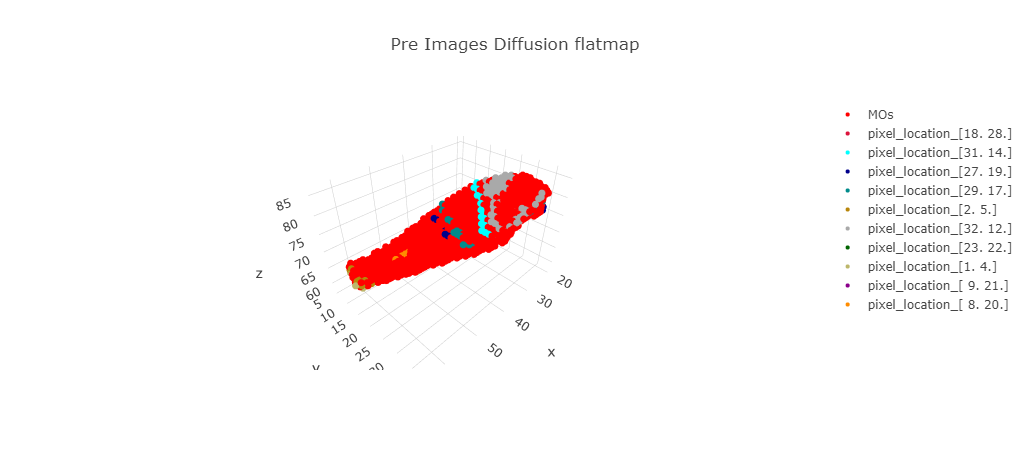

In [11]:

from plotly.offline import iplot
palette = ['crimson', 'cyan', 'darkblue', 'darkcyan',
            'darkgoldenrod', 'darkgray', 'darkgreen',
            'darkkhaki', 'darkmagenta', 'darkorange',
            'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
            'darkslateblue', 'darkslategray', 'darkslategrey',
            'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
            'dimgray','dimgrey', 'dodgerblue', 'firebrick',
            'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro',
            'ghostwhite', 'gold', 'goldenrod', 'gray', 'green',
            'greenyellow', 'honeydew', 'hotpink', 'indianred', 'indigo',
            'limegreen','linen', 'magenta', 'maroon', 'mediumaquamarine',
                'mediumblue', 'mediumorchid', 'mediumpurple',
                'mediumseagreen', 'mediumslateblue', 'mediumspringgreen',
                'mediumturquoise', 'mediumvioletred', 'midnightblue',
                'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy',
                'oldlace', 'olive', 'olivedrab', 'orange', 'orangered',
                'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise',
                'palevioletred', 'papayawhip']

sub_plot = []
i = 0
# To add the whole region in the plot
X = coords_3d[:,0]
Y = coords_3d[:,1]
Z = coords_3d[:,2]
sub_plot.append(
    dict(
    mode = "markers",
    name = region,
    type = "scatter3d",
    x = X, y = Y, z = Z,
    marker = dict(size=4, color='red')
    )
)
for pre_image in pre_images:
    colour = palette[i]
    name = f'pixel_location_{pxl_idx[i]}'
    i += 1
    X = pre_image[:,0]
    Y = pre_image[:,1]
    Z = pre_image[:,2]
    sub_plot.append(
        dict(
        mode = "markers",
        name = name,
        type = "scatter3d",
        x = X, y = Y, z = Z,
        marker = dict(size=4, color=colour)
        )
    )
layout = dict(
    title = 'Pre Images Diffusion flatmap',
    scene = dict(
        xaxis = dict(zeroline=False),
        yaxis = dict(zeroline=False),
        zaxis = dict(zeroline=False),
    )
)
fig = dict(data=sub_plot, layout=layout)
iplot(fig, filename='Pre Images')


*Next step, compute the betti curves of these pre images...*

In [1]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}